# IMDB Sentiment prediction
## 1. Setup


In [1]:
import re
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
import stopwords
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers


nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to /home/mateusz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mateusz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mateusz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mateusz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df =  pd.read_csv("./IMDB_Dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative":0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## 2. Cleanup
### 2.1 HTML

In [6]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    text_without_tags = soup.get_text(separator=' ')
    return text_without_tags

df["review"] = df["review"].apply(lambda x: remove_html_tags(x))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming te...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### 2.2 Removing contractions

In [7]:
def remove_contractions(text):
    # This solution is copied from an answer to a stackoverflow question:
    # https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

df["review"] = df["review"].apply(lambda x: remove_contractions(x))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming te...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there is a family where a little boy...,0
4,"Petter Mattei is ""Love in the Time of Money"" i...",1


### 2.3 Punctuation

In [8]:
def remove_punctuation(text):
    text_list_without_punctuation = [letter for letter in text if letter not in string.punctuation]
    text_without_punctuation = ''.join(text_list_without_punctuation)
    return text_without_punctuation

df["review"] = df["review"].apply(lambda x: remove_punctuation(x))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there is a family where a little boy...,0
4,Petter Mattei is Love in the Time of Money is ...,1


### 2.4 Whitespaces

In [9]:
def remove_whitespace(text):
    pattern = re.compile(r'\s+')
    text_without_whitespace = re.sub(pattern, ' ', text)
    return text_without_whitespace

df["review"] = df["review"].apply(lambda x: remove_whitespace(x))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there is a family where a little boy...,0
4,Petter Mattei is Love in the Time of Money is ...,1


### 2.5 Lowercase

In [10]:
def text_to_lower(text):
    return text.lower()

df["review"] = df["review"].apply(lambda x: text_to_lower(x))
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter mattei is love in the time of money is ...,1


### 2.6 Stopwords

In [11]:
stoplist = stopwords.get_stopwords("english")
stoplist = set(stoplist)

def remove_stopwords(text):
    no_stopwords_list = [word for word in word_tokenize(text) if word not in stoplist]
    no_stopwords_text = " ".join(no_stopwords_list)
    return no_stopwords_text

df["review"] = df["review"].apply(lambda x: remove_stopwords(x))
df.head()

,review,sentiment
0,one reviewers mentioned watching just 1 oz epi...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


### 2.7 Lemmatization

In [12]:
tag_map = defaultdict(lambda : wordnet.NOUN)
tag_map['J'] = wordnet.ADJ
tag_map['V'] = wordnet.VERB
tag_map['R'] = wordnet.ADV

def lemmatize(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = []
    lemmatizer = WordNetLemmatizer()
    for token, tag in pos_tag(tokens):
        lemmatized_token = lemmatizer.lemmatize(token, tag_map[tag[0]])
        lemmatized_tokens.append(lemmatized_token)
    return ' '.join(lemmatized_tokens)

df["review"] = df["review"].apply(lambda x: lemmatize(x))
df.head()

,review,sentiment
0,one reviewer mention watch just 1 oz episode w...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


## 3. Visualization

In [13]:
sentences = df["review"]
positive_reviews = ' '.join(sentences[df["sentiment"] == 1])
negative_reviews = ' '.join(sentences[df["sentiment"] == 0])
positive_wordcloud = WordCloud(width=800, height=800, background_color="black",
                               min_font_size=12).generate(positive_reviews)

negative_wordcloud = WordCloud(width=800, height=800, background_color="black",
                               min_font_size=12).generate(negative_reviews)

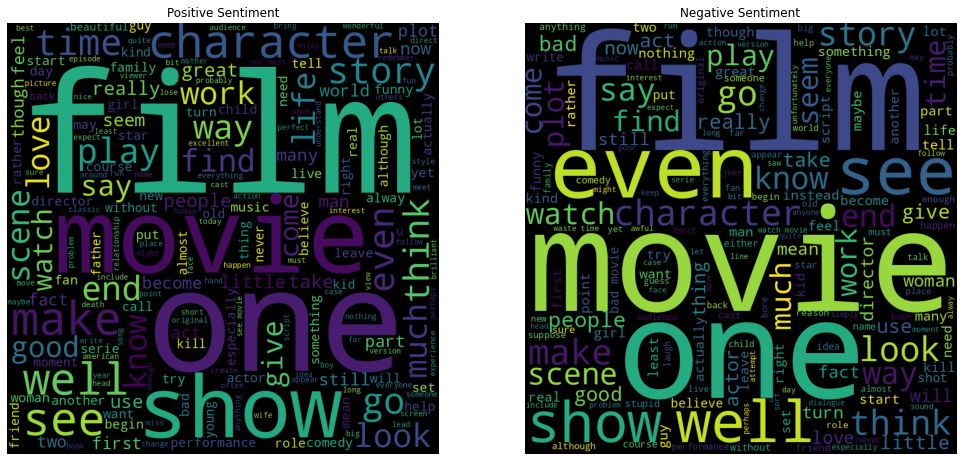

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
ax[0].imshow(positive_wordcloud)
ax[0].set_title("Positive Sentiment")
ax[0].axis("off")
ax[1].imshow(negative_wordcloud)
ax[1].set_title("Negative Sentiment")
ax[1].axis("off");

Text(0.5, 1.0, 'Top 20 negative words')

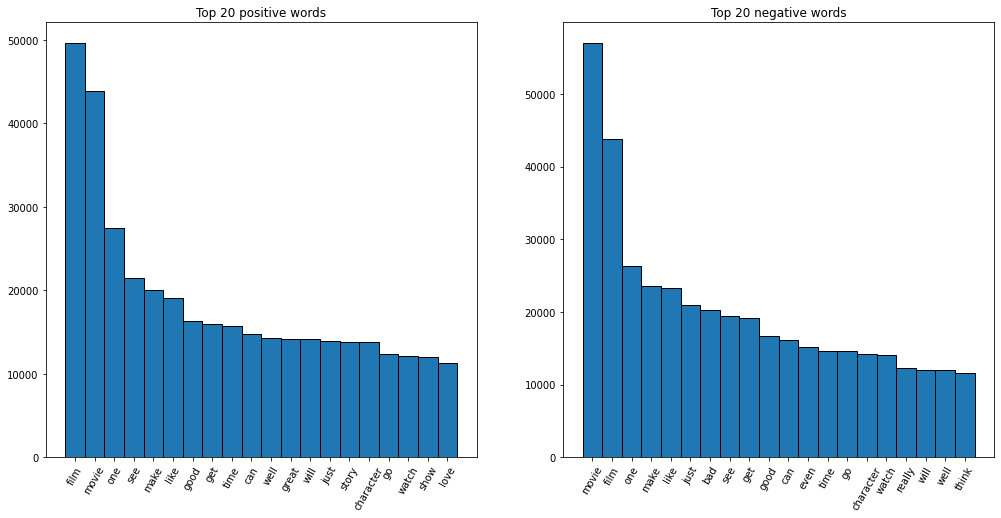

In [15]:
negative_words_counter = Counter(negative_reviews.split()).most_common()
neg_labels, neg_counts = zip(*negative_words_counter)


positive_words_counter = Counter(positive_reviews.split()).most_common()
pos_labels, pos_counts = zip(*positive_words_counter)
limit = 20
width = 1
indexes = np.arange(limit)

_, ax = plt.subplots(1, 2, figsize=(17,8))
# positive
ax[0].bar(indexes, pos_counts[:limit], width, align="edge", edgecolor="black")
ax[0].set_xticks(indexes + width * 0.5, pos_labels[:limit], rotation=60)
ax[0].set_title("Top 20 positive words")
# negative
ax[1].bar(indexes, neg_counts[:limit], width, align="edge", edgecolor="black")
ax[1].set_xticks(indexes + width * 0.5, neg_labels[:limit], rotation=60)
ax[1].set_title("Top 20 negative words")


## 4. Processing
### 4.1 Tokenization

In [ ]:
all_reviews = positive_reviews + negative_reviews
words = all_reviews.split()
count_words = Counter(words)
total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [17]:
prev_reviews = df["review"]

In [33]:
vocab_limit = 10000

vocab_to_int = {word: i + 1 for i, (word, _) in enumerate(sorted_words[:vocab_limit])}

In [19]:
df["review"] = df["review"].apply(lambda x: [vocab_to_int[word] for word in x.split() if word in vocab_to_int.keys()])
df.head()

,review,sentiment
0,"[3, 983, 318, 15, 8, 373, 2823, 187, 16, 1723,...",1
1,"[295, 52, 238, 2, 1487, 1083, 32, 3130, 423, 1...",1
2,"[21, 295, 35, 479, 11, 737, 1223, 2038, 347, 6...",1
3,"[550, 123, 52, 241, 2852, 21, 520, 3159, 551, ...",0
4,"[9139, 36, 11, 194, 1789, 3405, 2, 15, 305, 91...",1


<AxesSubplot:>

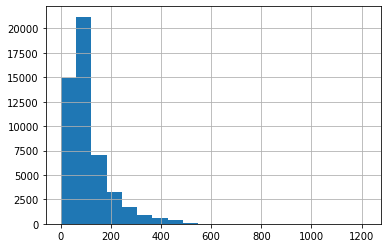

In [20]:
reviews_len = pd.Series([len(review) for review in df["review"]])
reviews_len.hist(bins=20)

In [21]:
reviews_len.describe()

count    50000.000000
mean       108.549140
std         80.431354
min          2.000000
25%         59.000000
50%         81.000000
75%        132.000000
max       1215.000000
dtype: float64

In [22]:
seq_length = 300
reviews_len[reviews_len > seq_length]

29       325
33       310
48       331
101      353
156      379
        ... 
49885    324
49904    349
49925    333
49948    431
49981    401
Length: 1947, dtype: int64

In [23]:
def pad_features(review):
    if len(review) <= seq_length:
        zeros = list(np.zeros(seq_length - len(review)))
        new_features = review + zeros
    else:
        new_features = review[:seq_length]

    return new_features

df["review"] = df["review"].apply(lambda x: pad_features(x))

## 5. Model
### 5.1 Splitting Data

In [24]:
X = df["review"].tolist()
y = df["sentiment"].tolist()

test_size = 0.1
validation_set_length = int(test_size / 2 * df.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

X_validate = X_test[:validation_set_length]
y_validate = y_test[:validation_set_length]

X_test = X_test[validation_set_length:]
y_test = y_test[validation_set_length:]

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_validate = np.array(X_validate)
y_validate = np.array(y_validate)

### 5.2 Model

2022-02-23 12:57:16.504176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 12:57:16.509558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 12:57:16.509724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 12:57:16.510184: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

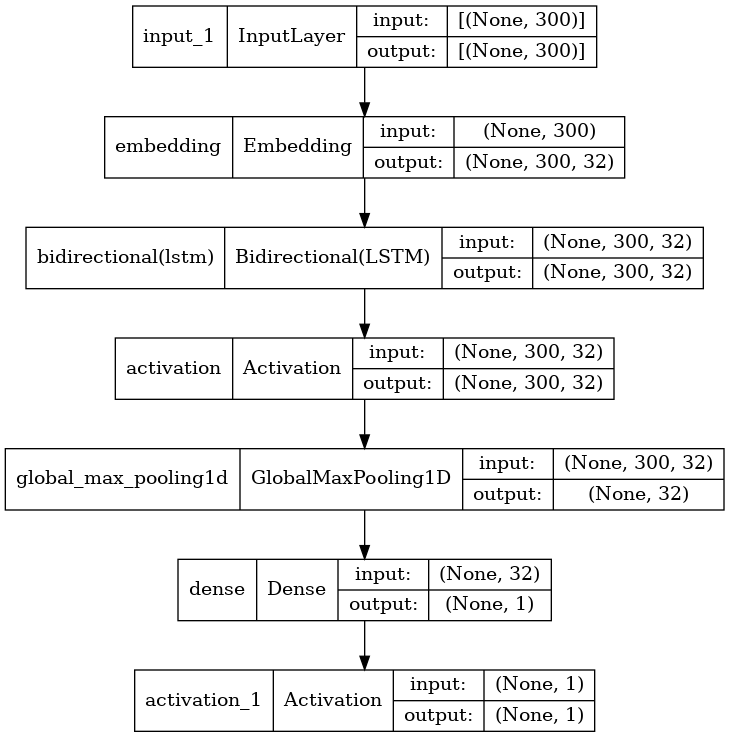

In [25]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Embedding(vocab_limit, 32)(inputs)
    x = layers.Bidirectional(layers.LSTM(16, dropout=0.1, return_sequences=True))(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Dense(1)(x)
    outputs = layers.Activation("sigmoid")(x)

    return keras.Model(inputs, outputs)

own_model = make_model(input_shape=seq_length)
keras.utils.plot_model(own_model, show_shapes=True)

In [26]:
def train_model(model, epochs, batch_size):
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=epochs // 5,
            verbose=1,
            min_delta=0.1,
            restore_best_weights=True)
       ]

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_validate, y_validate),
        callbacks=callbacks,
    )

In [27]:
def plot_model_performance(history):
       loss = history.history['loss']
       accuracy = history.history['accuracy']
       val_loss = history.history['val_loss']
       val_accuracy = history.history['val_accuracy']
       x_axis = [i for i in range(len(loss))]


       _, sub = plt.subplots(1, 2)
       sub[0].plot(x_axis, loss, 'y', label="Training loss")
       sub[0].plot(x_axis, val_loss, 'b', label="Validation loss")
       sub[0].set_title("Training and validation loss")
       sub[0].set_xlabel("Epochs")
       sub[0].set_ylabel("Loss")
       sub[0].legend()

       sub[1].plot(x_axis, accuracy, 'y', label="Training accuracy")
       sub[1].plot(x_axis, val_accuracy, 'b', label="Validation accuracy")
       sub[1].set_title("Training and validation accuracy")
       sub[1].set_xlabel("Epochs")
       sub[1].set_ylabel("Loss")

In [28]:
own_history = train_model(own_model, 40, 128)

Epoch 1/40


2022-02-23 12:57:19.517928: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


  4/352 [..............................] - ETA: 7s - loss: 0.6930 - accuracy: 0.5020   

2022-02-23 12:57:20.010942: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


352/352 [==============================] - 11s 23ms/step - loss: 0.5009 - accuracy: 0.7735 - val_loss: 0.3322 - val_accuracy: 0.8584
Epoch 2/40
352/352 [==============================] - 7s 21ms/step - loss: 0.2854 - accuracy: 0.8854 - val_loss: 0.2986 - val_accuracy: 0.8780
Epoch 3/40
352/352 [==============================] - 7s 21ms/step - loss: 0.2366 - accuracy: 0.9089 - val_loss: 0.2837 - val_accuracy: 0.8820
Epoch 4/40
352/352 [==============================] - 7s 21ms/step - loss: 0.2042 - accuracy: 0.9223 - val_loss: 0.2782 - val_accuracy: 0.8836
Epoch 5/40
352/352 [==============================] - 7s 21ms/step - loss: 0.1842 - accuracy: 0.9313 - val_loss: 0.2892 - val_accuracy: 0.8764
Epoch 6/40
352/352 [==============================] - 7s 21ms/step - loss: 0.1633 - accuracy: 0.9405 - val_loss: 0.2969 - val_accuracy: 0.8812
Epoch 7/40
352/352 [==============================] - 7s 21ms/step - loss: 0.1527 - accuracy: 0.9443 - val_loss: 0.3095 - val_accuracy: 0.8812
Epoch 8/4

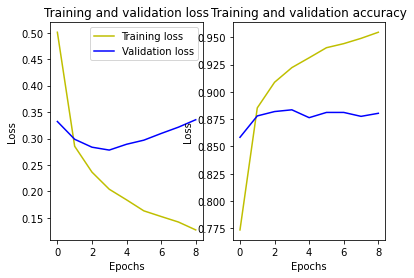

In [31]:
plot_model_performance(own_history)

In [30]:
own_model.evaluate(X_test, y_test)

79/79 [==============================] - 1s 10ms/step - loss: 0.3177 - accuracy: 0.8676


[0.3176746368408203, 0.8676000237464905]